# Project Baudet Baligand

## Project Overview
TODO:Intro, problem statement, metrics ( I would choose Area under roc curve)

## Data Exploration

In [1]:
# Useful modules, make sure you can import them before proceeding further
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import json
import string
import os
from sklearn import dummy
import seaborn as sbn
from pandas.io.json import json_normalize
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing, neighbors

# Random seed to make results reducible
SEED = 1

We need to extract the data, and convert the data given in "json" to a dataframe in order to perform our analysis

In [2]:
my_list = []
with open('amazon_step1.json') as f:
    for line in f:
        my_list.append(json.loads(line))

df = json_normalize(my_list)

In [66]:
df = df.iloc[:5000]

In [3]:
df.head(1)

,asin,category,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000J4HXUC,Sports_and_Outdoors,"[1, 1]",5.0,It's a .50 Caliber Ammo Can. That largely sums...,"01 5, 2014",A3QRW0UJPKIAX7,Grant Fritchey,Clean and Exactly as Advertised,1388880000


In [4]:
#Check if we have any null values
print (df.isnull().sum())

asin                0
category            0
helpful             0
overall             0
reviewText          0
reviewTime          0
reviewerID          0
reviewerName      994
summary             0
unixReviewTime      0
dtype: int64


In [5]:
df.describe()

,overall,unixReviewTime
count,96000.000000,9.600000e+04
mean,4.260271,1.333697e+09
std,1.103461,9.034763e+07
min,1.000000,8.827488e+08
25%,4.000000,1.323821e+09
50%,5.000000,1.365898e+09
75%,5.000000,1.388102e+09
max,5.000000,1.406074e+09


96000

/home/louis_baligand/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


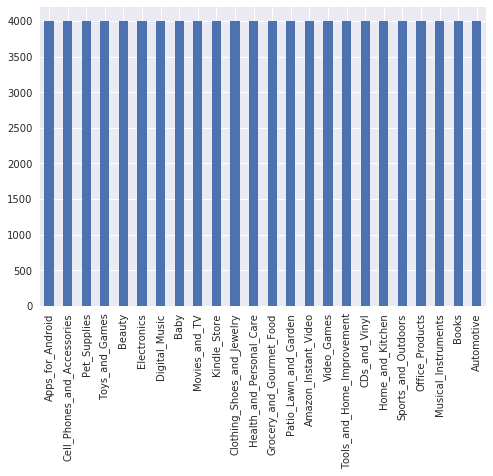

In [6]:
# histogram of categories
fig, ax = plt.subplots()
df['category'].value_counts().plot(ax=ax, kind='bar')
df['category'].value_counts().sum()

/home/louis_baligand/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


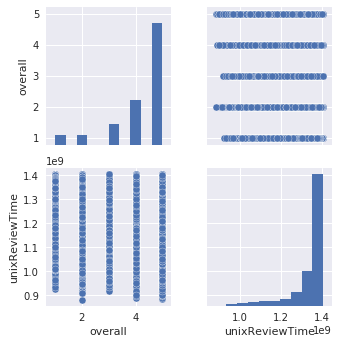

In [7]:
# visualize distribution of features and pairwise relationship using seaborn pairplot
sbn.pairplot(df)

In [8]:
df.corr()

,overall,unixReviewTime
overall,1.000000,0.037631
unixReviewTime,0.037631,1.000000


## Data Pre Processing

We will map the 24 categories to numerical values from 0 to 23.

In [3]:
df['category'] = df['category'].astype('category')

mapper = dict( enumerate(df.category.cat.categories) )
print(mapper)
df['category_encode'] = df['category'].cat.codes
print(df['category_encode'])

{0: 'Amazon_Instant_Video', 1: 'Apps_for_Android', 2: 'Automotive', 3: 'Baby', 4: 'Beauty', 5: 'Books', 6: 'CDs_and_Vinyl', 7: 'Cell_Phones_and_Accessories', 8: 'Clothing_Shoes_and_Jewelry', 9: 'Digital_Music', 10: 'Electronics', 11: 'Grocery_and_Gourmet_Food', 12: 'Health_and_Personal_Care', 13: 'Home_and_Kitchen', 14: 'Kindle_Store', 15: 'Movies_and_TV', 16: 'Musical_Instruments', 17: 'Office_Products', 18: 'Patio_Lawn_and_Garden', 19: 'Pet_Supplies', 20: 'Sports_and_Outdoors', 21: 'Tools_and_Home_Improvement', 22: 'Toys_and_Games', 23: 'Video_Games'}
0        20
1         5
2        11
3         7
4         0
5         3
6        21
7         9
8        19
9        15
10       23
11       14
12       20
13       20
14        7
15       19
16       19
17       22
18       13
19       14
20       13
21        8
22        1
23       12
24        6
25        4
26        4
27       16
28       14
29       15
         ..
95970     6
95971    10
95972    20
95973     6
95974     1
95975   

In [4]:
# adding summary to reviewText
df['reviewText'] = df['summary'] + ' ' + df['reviewText']

In [5]:
# convert text to lowercase
df.loc[:, 'reviewText'] = df['reviewText'].str.lower()

We then build our Tfidf matrix _features_

In [12]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

#create a stemmer
stemmer = SnowballStemmer("english")


#define our own tokenizing function that we will pass into the TFIDFVectorizer. We will also stem the words here.
def tokens(x):
    x = x.split()
    stems = []
    [stems.append(stemmer.stem(word)) for word in x]
    return stems

#define the vectorizer
vectorizer = TfidfVectorizer(tokenizer = tokens, stop_words = 'english', ngram_range=(1, 1), min_df = 0.01)
#fit the vectorizers to the data.
features = vectorizer.fit_transform(df['reviewText'])
features

<96000x762 sparse matrix of type '<class 'numpy.float64'>'
	with 2251423 stored elements in Compressed Sparse Row format>

In [6]:
# Try to build the tfidf matrix as in assignment 1
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords

stoplist = set('i me my myself we our ours ourselves you your yours yourself yourselves he him his himself she her hers herself it its itself they them their theirs themselves what which who whom this that these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don should now'.split())

stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

stem_vectorizer = CountVectorizer(analyzer=stemmed_words)

# set up pipeline with the modified CountVectorizer
pipe_modified = Pipeline([('vectorize_stem', CountVectorizer(stop_words=stoplist,analyzer=stemmed_words)),\
                          ('compute_tfidf', TfidfTransformer())])

# fit modified pipeline, then carry out vectorization and transformation in one shot
pipe_modified.fit(df['reviewText'])
documents_tfidf = pipe_modified.transform(df['reviewText'])

In [12]:
documents_tfidf.shape

(96000, 91422)

## Step 1

In [7]:
from sklearn.model_selection import train_test_split

cat_coded = df['category_encode'].values.tolist()

# Split the data in 80% training set and 20% test set
X_train, X_test, y_train, y_test = train_test_split(documents_tfidf, cat_coded, test_size=0.2, random_state=SEED)

As a baseline model to assess the performance of our prediction we will use the following dummy classifier. Note that we use the stratified strategy.

In [80]:
# set up dummy classifier and fit it to training data
clf_dummy = dummy.DummyClassifier(strategy="uniform", random_state=SEED)
clf_dummy.fit(X_train, y_train)
clf_dummy.score(X_test, y_test)

0.050999999999999997

In [81]:
y_pred = clf_dummy.predict(X_test)
print("accuracy :", np.mean(y_pred == y_test))

accuracy : 0.051


false positive rates: [ 0.  1.]
true positive rates:  [ 0.  1.]
thresholds: [ 1.04166667  0.04166667]
area under roc curve:  0.5


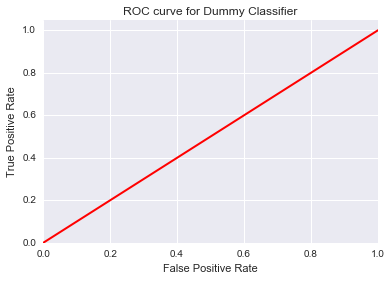

In [82]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# DUMMY classifier returned probabilities
clf_dummy_pred = clf_dummy.predict_proba(X_test)

# compute false positive rate, true positive rate and thresholds defining ROC curve
# (note: these values define the points at which the ROC curve has a kink)
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_test, clf_dummy_pred[:,1], pos_label=1)
print('false positive rates:', fpr_dummy)
print('true positive rates: ', tpr_dummy)
print('thresholds:', thresholds_dummy)

# compute and show area under the ROC curve
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)
print ('area under roc curve: ', roc_auc_dummy)

# plot the ROC curve
plt.plot(fpr_dummy, tpr_dummy, color='red',lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC curve for Dummy Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [35]:
# define a pipeline with maxabs standardization preprocessing with Euclidean measure of distance
estimators = []
estimators.append(('MaxAbsScalar', preprocessing.MaxAbsScaler()))
estimators.append(('knn_cls', neighbors.KNeighborsClassifier()))
cls_knn_pipe = Pipeline(estimators)
cls_knn_pipe.set_params(knn_cls__algorithm='brute')
cls_knn_pipe.set_params(knn_cls__weights='distance')

# create a grid search over n_neighbors values
parameters = {
        'knn_cls__n_neighbors' : np.arange(1,100, 5)
}
estimator_knncls = GridSearchCV(cls_knn_pipe, parameters, cv=5, n_jobs=-1)
                  
# evaluate the grid search and print best estimator
estimator_knncls.fit(X_train, y_train)
estimator_knncls.best_estimator_

Process ForkPoolWorker-87:
Process ForkPoolWorker-80:
Process ForkPoolWorker-82:
Process ForkPoolWorker-84:
Process ForkPoolWorker-83:
Process ForkPoolWorker-75:
Process ForkPoolWorker-86:
Process ForkPoolWorker-85:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/louis_baligand/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/louis_baligand/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/louis_baligand/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/louis_baligand/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/louis_baligand/anaconda3/lib/python3.6/mu

TypeError: catching classes that do not inherit from BaseException is not allowed

In [ ]:
# fix the number of neighbors to the best value
cls_knn_pipe.set_params(knn_cls__n_neighbors=38)

# fit the model to the training set
cls_knn_pipe.fit(X_train, y_train)

# assess the performance on the test set using R^2 score
cls_knn_pipe.score(X_test, y_test)

In [8]:
# setup pipeline
estimators = []
estimators.append(('normalize', Normalizer()))
estimators.append(('svm_clf', svm.SVC()))
pipe = Pipeline(estimators)
pipe.set_params(svm_clf__kernel='linear')

# tuning requsted parameter
tuned_parameters = [{'svm_clf__C': np.logspace(-5,15,8,base=2.0)}]
clf = GridSearchCV(pipe, tuned_parameters, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
clf.fit(X_train,y_train)
clf.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] svm_clf__C=0.03125 ..............................................
[CV] svm_clf__C=0.03125 ..............................................
[CV] svm_clf__C=0.03125 ..............................................
[CV] svm_clf__C=0.03125 ..............................................
[CV] svm_clf__C=0.03125 ..............................................
[CV] svm_clf__C=0.226430916066 .......................................
[CV] svm_clf__C=0.226430916066 .......................................
[CV] svm_clf__C=0.226430916066 .......................................
[CV] ........................ svm_clf__C=0.226430916066, total=69.5min
[CV] svm_clf__C=0.226430916066 .......................................
[CV] ........................ svm_clf__C=0.226430916066, total=69.5min
[CV] svm_clf__C=0.226430916066 .......................................
[CV] ........................ svm_clf__C=0.226430916066, total=69.8min
[CV] svm_clf__C=1

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 315.9min


[CV] ......................... svm_clf__C=624.134990953, total=36.5min
[CV] svm_clf__C=4522.35064801 ........................................
[CV] ......................... svm_clf__C=624.134990953, total=36.4min
[CV] svm_clf__C=4522.35064801 ........................................
[CV] ......................... svm_clf__C=624.134990953, total=35.4min
[CV] svm_clf__C=32768.0 ..............................................
[CV] ......................... svm_clf__C=624.134990953, total=35.7min
[CV] svm_clf__C=32768.0 ..............................................
[CV] ......................... svm_clf__C=624.134990953, total=35.1min
[CV] svm_clf__C=32768.0 ..............................................
[CV] ......................... svm_clf__C=4522.35064801, total=35.4min
[CV] svm_clf__C=32768.0 ..............................................
[CV] ......................... svm_clf__C=4522.35064801, total=35.2min
[CV] svm_clf__C=32768.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 435.3min finished


{'svm_clf__C': 1.6406707120152759}

In [26]:
#save the results GridSearchCV 5-fold results with SVM classifier
clf_results = [0.63308593749999997, 0.73296874999999995, 0.75221354166666665, 0.72329427083333331, 0.71470052083333335, 0.71380208333333328, 0.71375, 0.71375]

/home/louis_baligand/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/louis_baligand/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


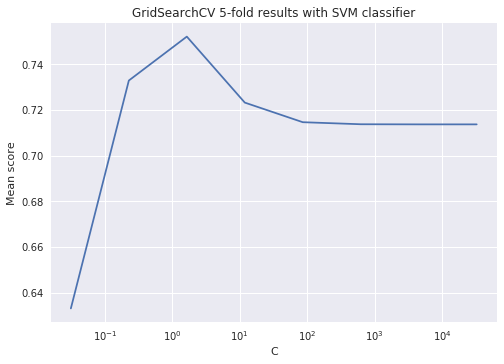

In [23]:
Cs = np.logspace(-5,15,8,base=2.0)
scores = [x[1] for x in clf.grid_scores_]
plt.plot(Cs, scores)
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Mean score')
plt.title('GridSearchCV 5-fold results with SVM classifier')
plt.show()

In [16]:
# best C value using GridSearchCV
best_C_SVC = 2

In [19]:
# assessing best performing SVC on test set
from sklearn.metrics import accuracy_score

# setup pipeline
estimators = []
estimators.append(('normalize', Normalizer()))
estimators.append(('svm_clf', svm.SVC()))
pipe = Pipeline(estimators)
pipe.set_params(svm_clf__kernel='linear', svm_clf__C=best_C_SVC)

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.75864583333333335

In [1]:
# setup pipeline
estimators = []
estimators.append(('normalize', Normalizer()))
estimators.append(('svm_clf', svm.SVC()))
pipe = Pipeline(estimators)
pipe.set_params(svm_clf__kernel='rbf', svm_clf__C=best_C_SVC)

pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
accuracy_score(y_test, y_pred)


NameError: name 'Normalizer' is not defined